# libs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
train_full = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_train_ver2.pkl')

temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

# LGBM ver1

In [ ]:
lgb_train = lgb.Dataset(data=train.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}

model_lgb_base = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 16882, number of negative: 192225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.309214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9440
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080734 -> initscore=-2.432419
[LightGBM] [Info] Start training from score -2.432419
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.747867	valid_1's auc: 0.741564
[100]	training's auc: 0.756255	valid_1's auc: 0.748521
[150]	training's auc: 0.763765	valid_1's auc: 0.753964
[200]	training's auc: 0.770738	valid_1's auc: 0.758961
[250]	training's auc: 0.77701	valid_1's auc: 0.763781
[300]	training's auc: 0.782509	valid_1's auc: 0.768076
[350]	training's auc: 0.786939	valid_1's auc: 0.771367
[400]	training's auc: 0.790927	valid_1's auc: 0.774144
[

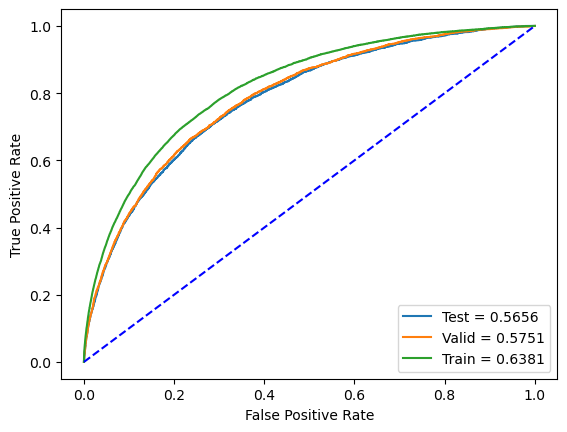

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_base.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = model_lgb_base.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = model_lgb_base.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

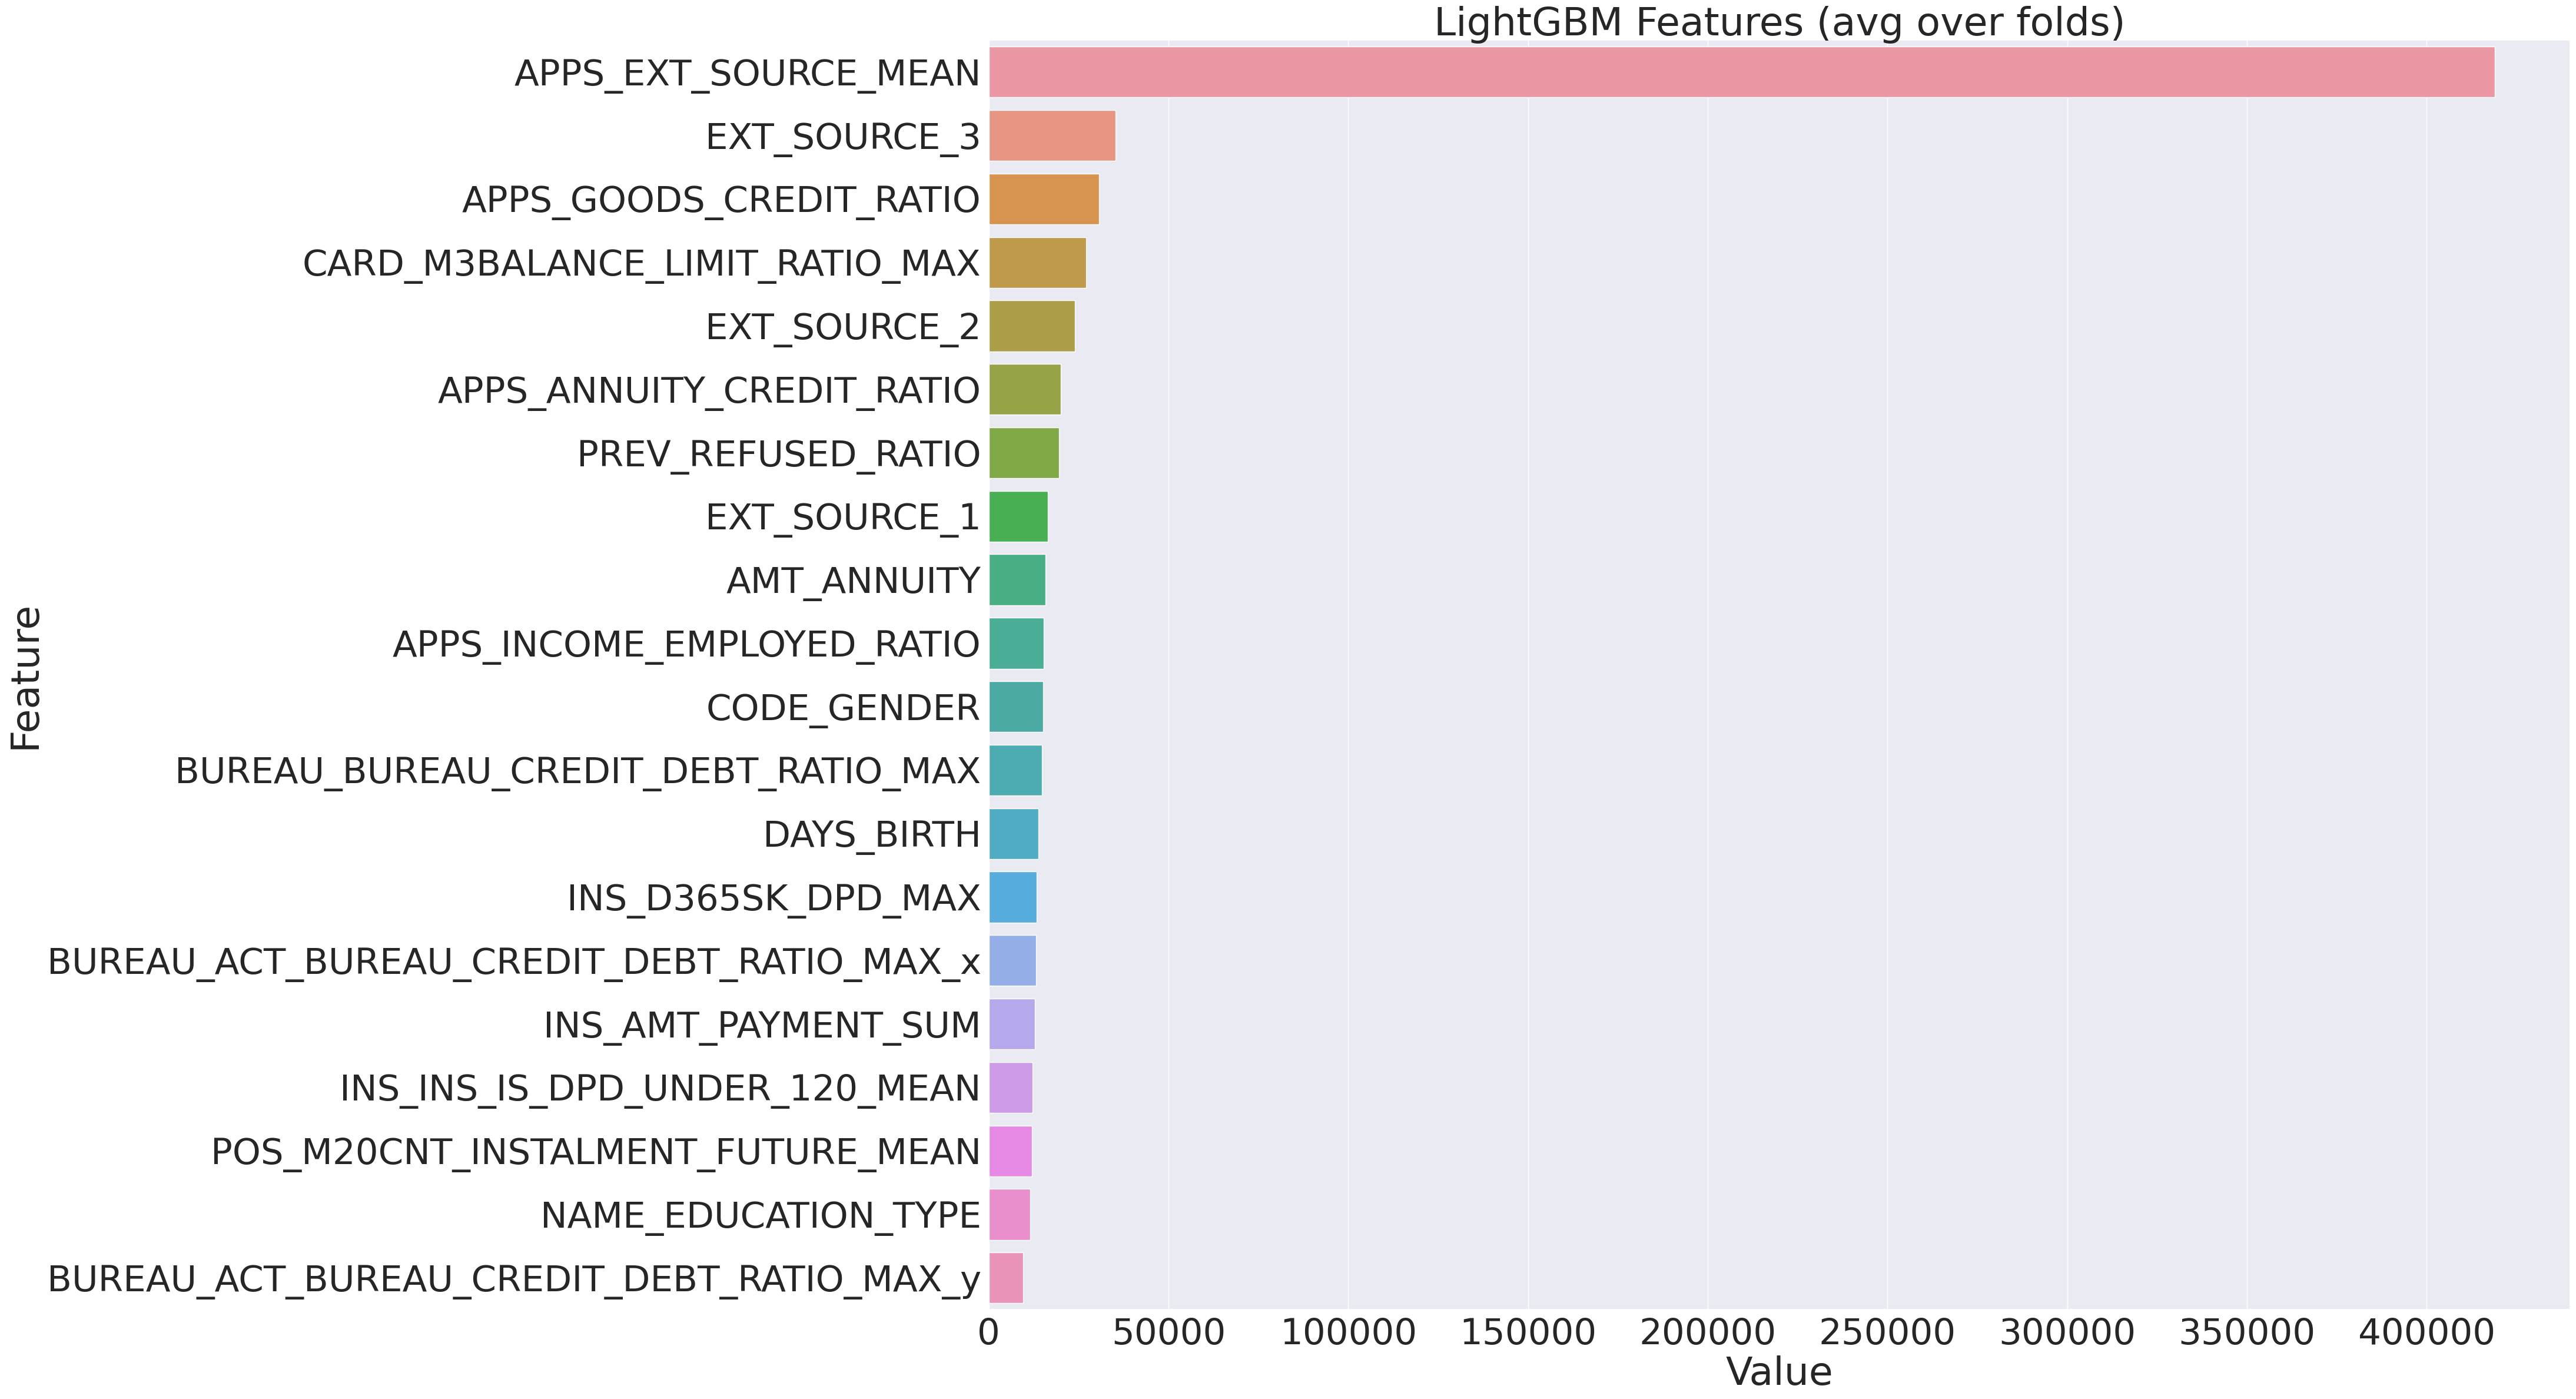

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_base)

In [ ]:
# plotImp(model = model_lgb_base)

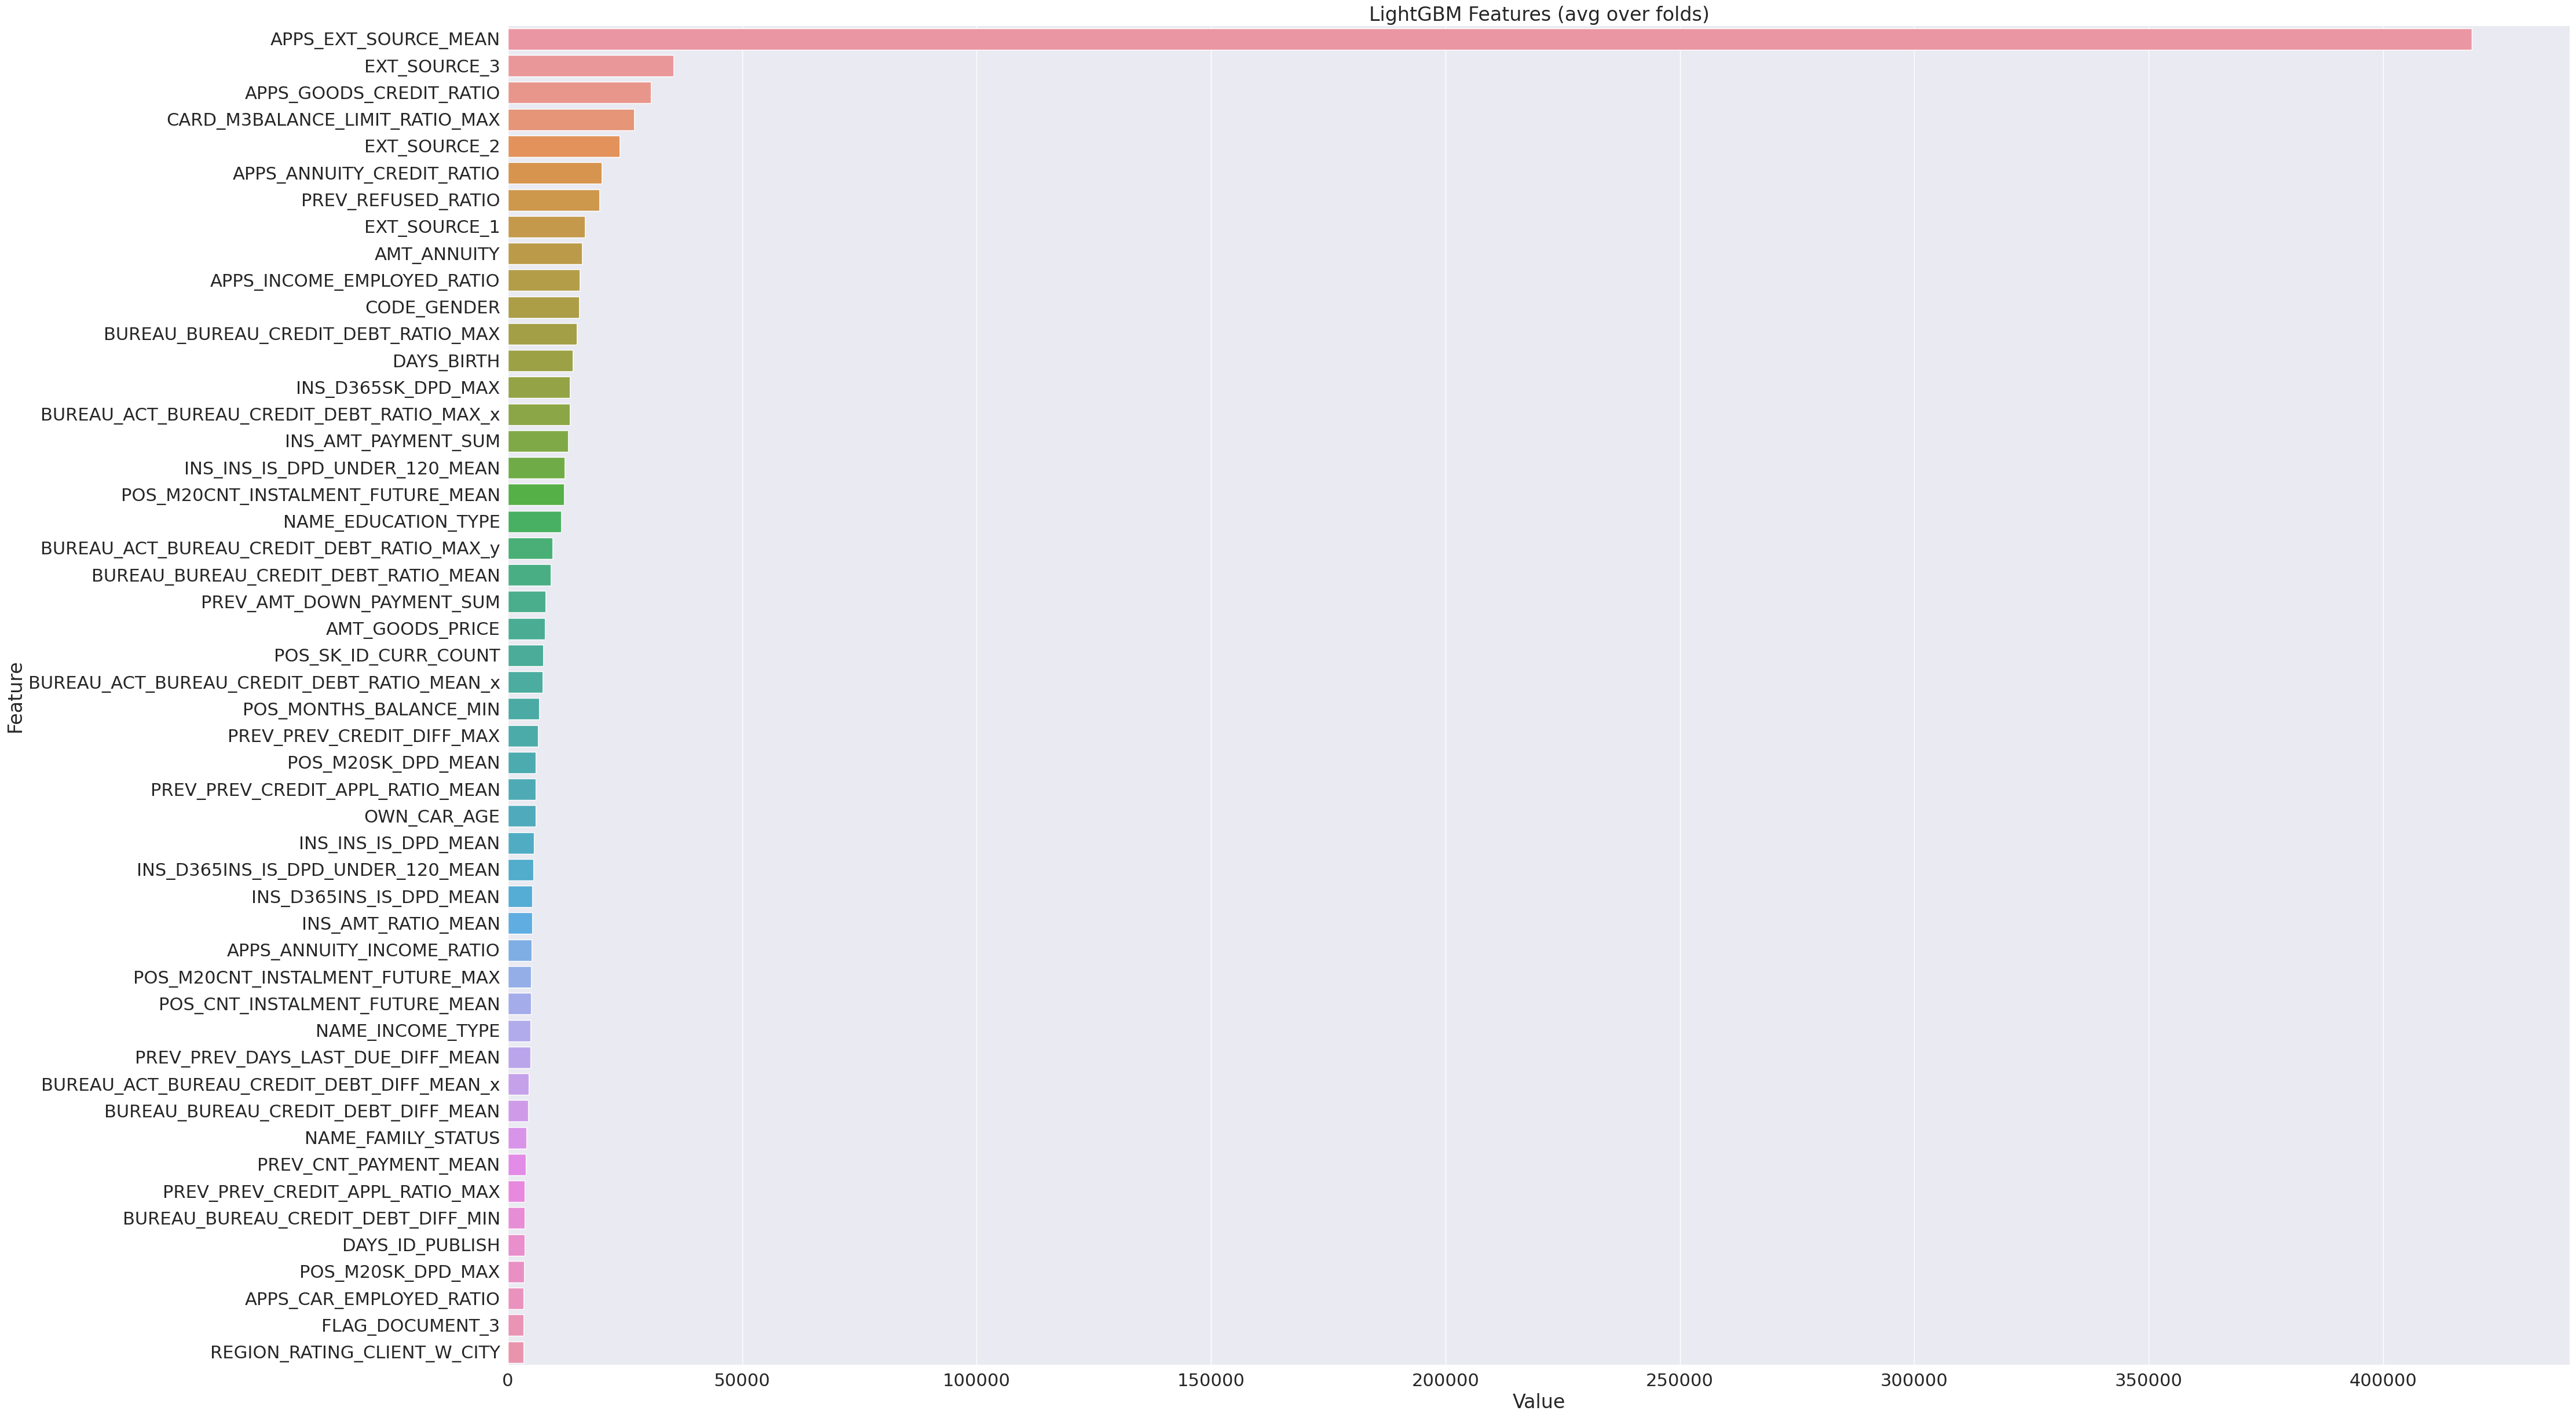

In [ ]:
plotImp(model = model_lgb_base, num = 50, font_scale = 2)

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model_lgb_base.feature_name(),
        'importance': model_lgb_base.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)

feature     importance
120             APPS_EXT_SOURCE_MEAN  418954.446362
41                      EXT_SOURCE_3   35295.726082
123          APPS_GOODS_CREDIT_RATIO   30565.298648
523   CARD_M3BALANCE_LIMIT_RATIO_MAX   26965.260032
40                      EXT_SOURCE_2   23902.861182
..                               ...            ...
164         PREV_PREV_GOODS_DIFF_SUM       0.000000
4                       CNT_CHILDREN       0.000000
162        PREV_PREV_GOODS_DIFF_MEAN       0.000000
163         PREV_PREV_GOODS_DIFF_MAX       0.000000
531  CARD_M3CARD_IS_DPD_OVER_120_SUM       0.000000

[532 rows x 2 columns]

In [ ]:
df_feature_importance[df_feature_importance['importance'] > 0 ].shape

(471, 2)

In [ ]:
df_feature_importance[df_feature_importance['importance'] > 0 ].head(50)

feature     importance
120                        APPS_EXT_SOURCE_MEAN  418954.446362
41                                 EXT_SOURCE_3   35295.726082
123                     APPS_GOODS_CREDIT_RATIO   30565.298648
523              CARD_M3BALANCE_LIMIT_RATIO_MAX   26965.260032
40                                 EXT_SOURCE_2   23902.861182
122                   APPS_ANNUITY_CREDIT_RATIO   20059.000799
211                          PREV_REFUSED_RATIO   19516.325164
39                                 EXT_SOURCE_1   16431.165827
7                                   AMT_ANNUITY   15790.886361
129                  APPS_INCOME_EMPLOYED_RATIO   15305.296273
1                                   CODE_GENDER   15162.669743
250         BUREAU_BUREAU_CREDIT_DEBT_RATIO_MAX   14761.745133
15                                   DAYS_BIRTH   13808.053618
456                          INS_D365SK_DPD_MAX   13206.477122
296   BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_x   13182.820945
418                         INS_AMT_PAYMENT_SUM   12868.164112
430               INS_INS_IS_DPD_UNDER_120_MEAN   12182.016147
397           POS_M20CNT_INSTALMENT_FUTURE_MEAN   12049.964392
11                          NAME_EDUCATION_TYPE   11429.408803
352   BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MAX_y    9569.086696
251        BUREAU_BUREAU_CREDIT_DEBT_RATIO_MEAN    9201.494883
145                   PREV_AMT_DOWN_PAYMENT_SUM    8049.902811
8                               AMT_GOODS_PRICE    7915.266699
361                        POS_SK_ID_CURR_COUNT    7599.481788
297  BUREAU_ACT_BUREAU_CREDIT_DEBT_RATIO_MEAN_x    7433.472970
362                      POS_MONTHS_BALANCE_MIN    6745.908182
158                   PREV_PREV_CREDIT_DIFF_MAX    6450.694905
389                          POS_M20SK_DPD_MEAN    5977.469689
160            PREV_PREV_CREDIT_APPL_RATIO_MEAN    5977.098613
19                                  OWN_CAR_AGE    5922.555889
428                         INS_INS_IS_DPD_MEAN    5533.595502
459           INS_D365INS_IS_DPD_UNDER_120_MEAN    5408.893923
457                     INS_D365INS_IS_DPD_MEAN    5157.548137
423                          INS_AMT_RATIO_MEAN    5152.057699
124                   APPS_ANNUITY_INCOME_RATIO    5123.140276
396            POS_M20CNT_INSTALMENT_FUTURE_MAX    5009.511197
375              POS_CNT_INSTALMENT_FUTURE_MEAN    4993.315587
10                             NAME_INCOME_TYPE    4830.139735
167           PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN    4817.778603
300   BUREAU_ACT_BUREAU_CREDIT_DEBT_DIFF_MEAN_x    4455.866994
254         BUREAU_BUREAU_CREDIT_DEBT_DIFF_MEAN    4319.672710
12                           NAME_FAMILY_STATUS    3914.413534
155                       PREV_CNT_PAYMENT_MEAN    3832.823104
161             PREV_PREV_CREDIT_APPL_RATIO_MAX    3612.927292
252          BUREAU_BUREAU_CREDIT_DEBT_DIFF_MIN    3579.802117
18                              DAYS_ID_PUBLISH    3551.752504
388                           POS_M20SK_DPD_MAX    3496.951404
132                     APPS_CAR_EMPLOYED_RATIO    3364.373307
95                              FLAG_DOCUMENT_3    3355.557411
29                  REGION_RATING_CLIENT_W_CITY    3348.664689

In [ ]:
final_feature = df_feature_importance[df_feature_importance['importance'] > 0]['feature'].to_list()
len(final_feature)

471

In [ ]:
df_feature_importance.to_csv('feature_importance_LGBM.csv', index = False)

In [ ]:
# test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
# pred = model_lgb_base.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1))

# test_kaggle['TARGET'] = pred
# test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index = False)

# Hyper params

In [ ]:
lgb_train = lgb.Dataset(data=train.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.018437, 
          'num_leaves': 58,
          'max_bin': 300,
          'num_iteration': 1000,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':7, 
          'reg_alpha':3.564, 
          'reg_lambda':4.930, 
          'min_child_weight':6}


model_lgb_tune_ver0 = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 16882, number of negative: 192225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.637206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111046
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080734 -> initscore=-2.432419
[LightGBM] [Info] Start training from score -2.432419
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.77937	valid_1's auc: 0.756766
[100]	training's auc: 0.795678	valid_1's auc: 0.767034
[150]	training's auc: 0.808524	valid_1's auc: 0.77403
[200]	training's auc: 0.818561	valid_1's auc: 0.779387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	training's auc: 0.82669	valid_1's auc: 0.782911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

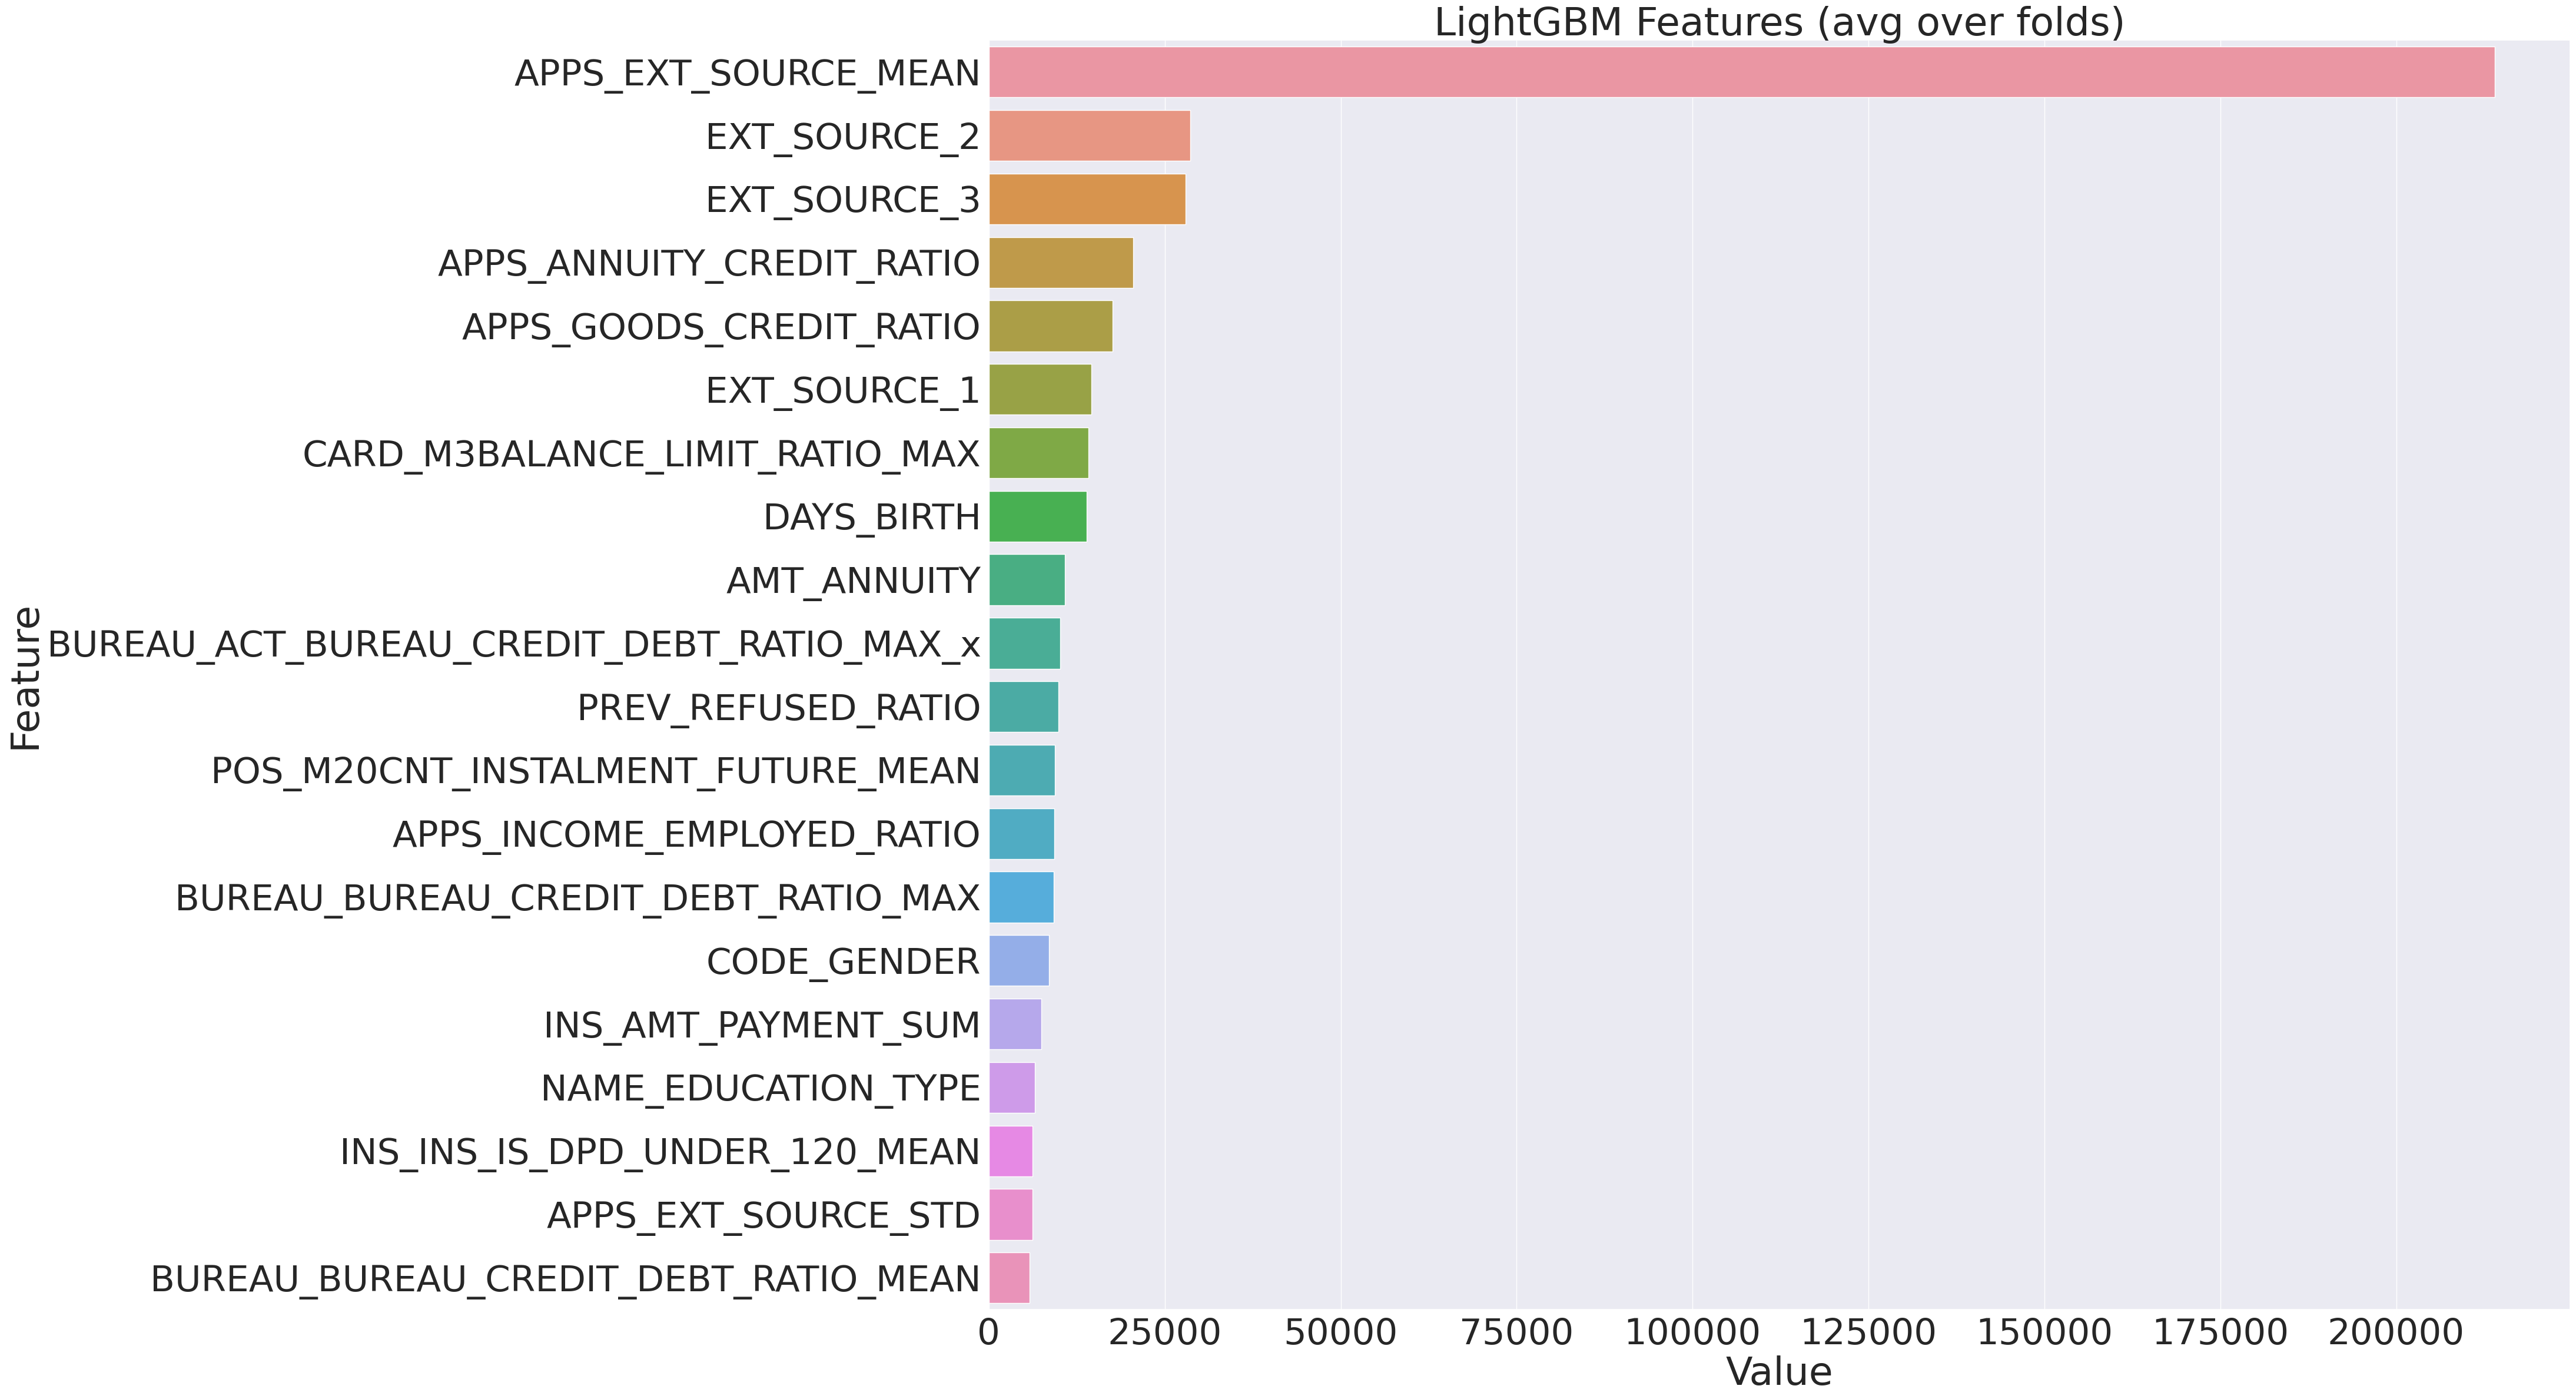

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_tune_ver0)

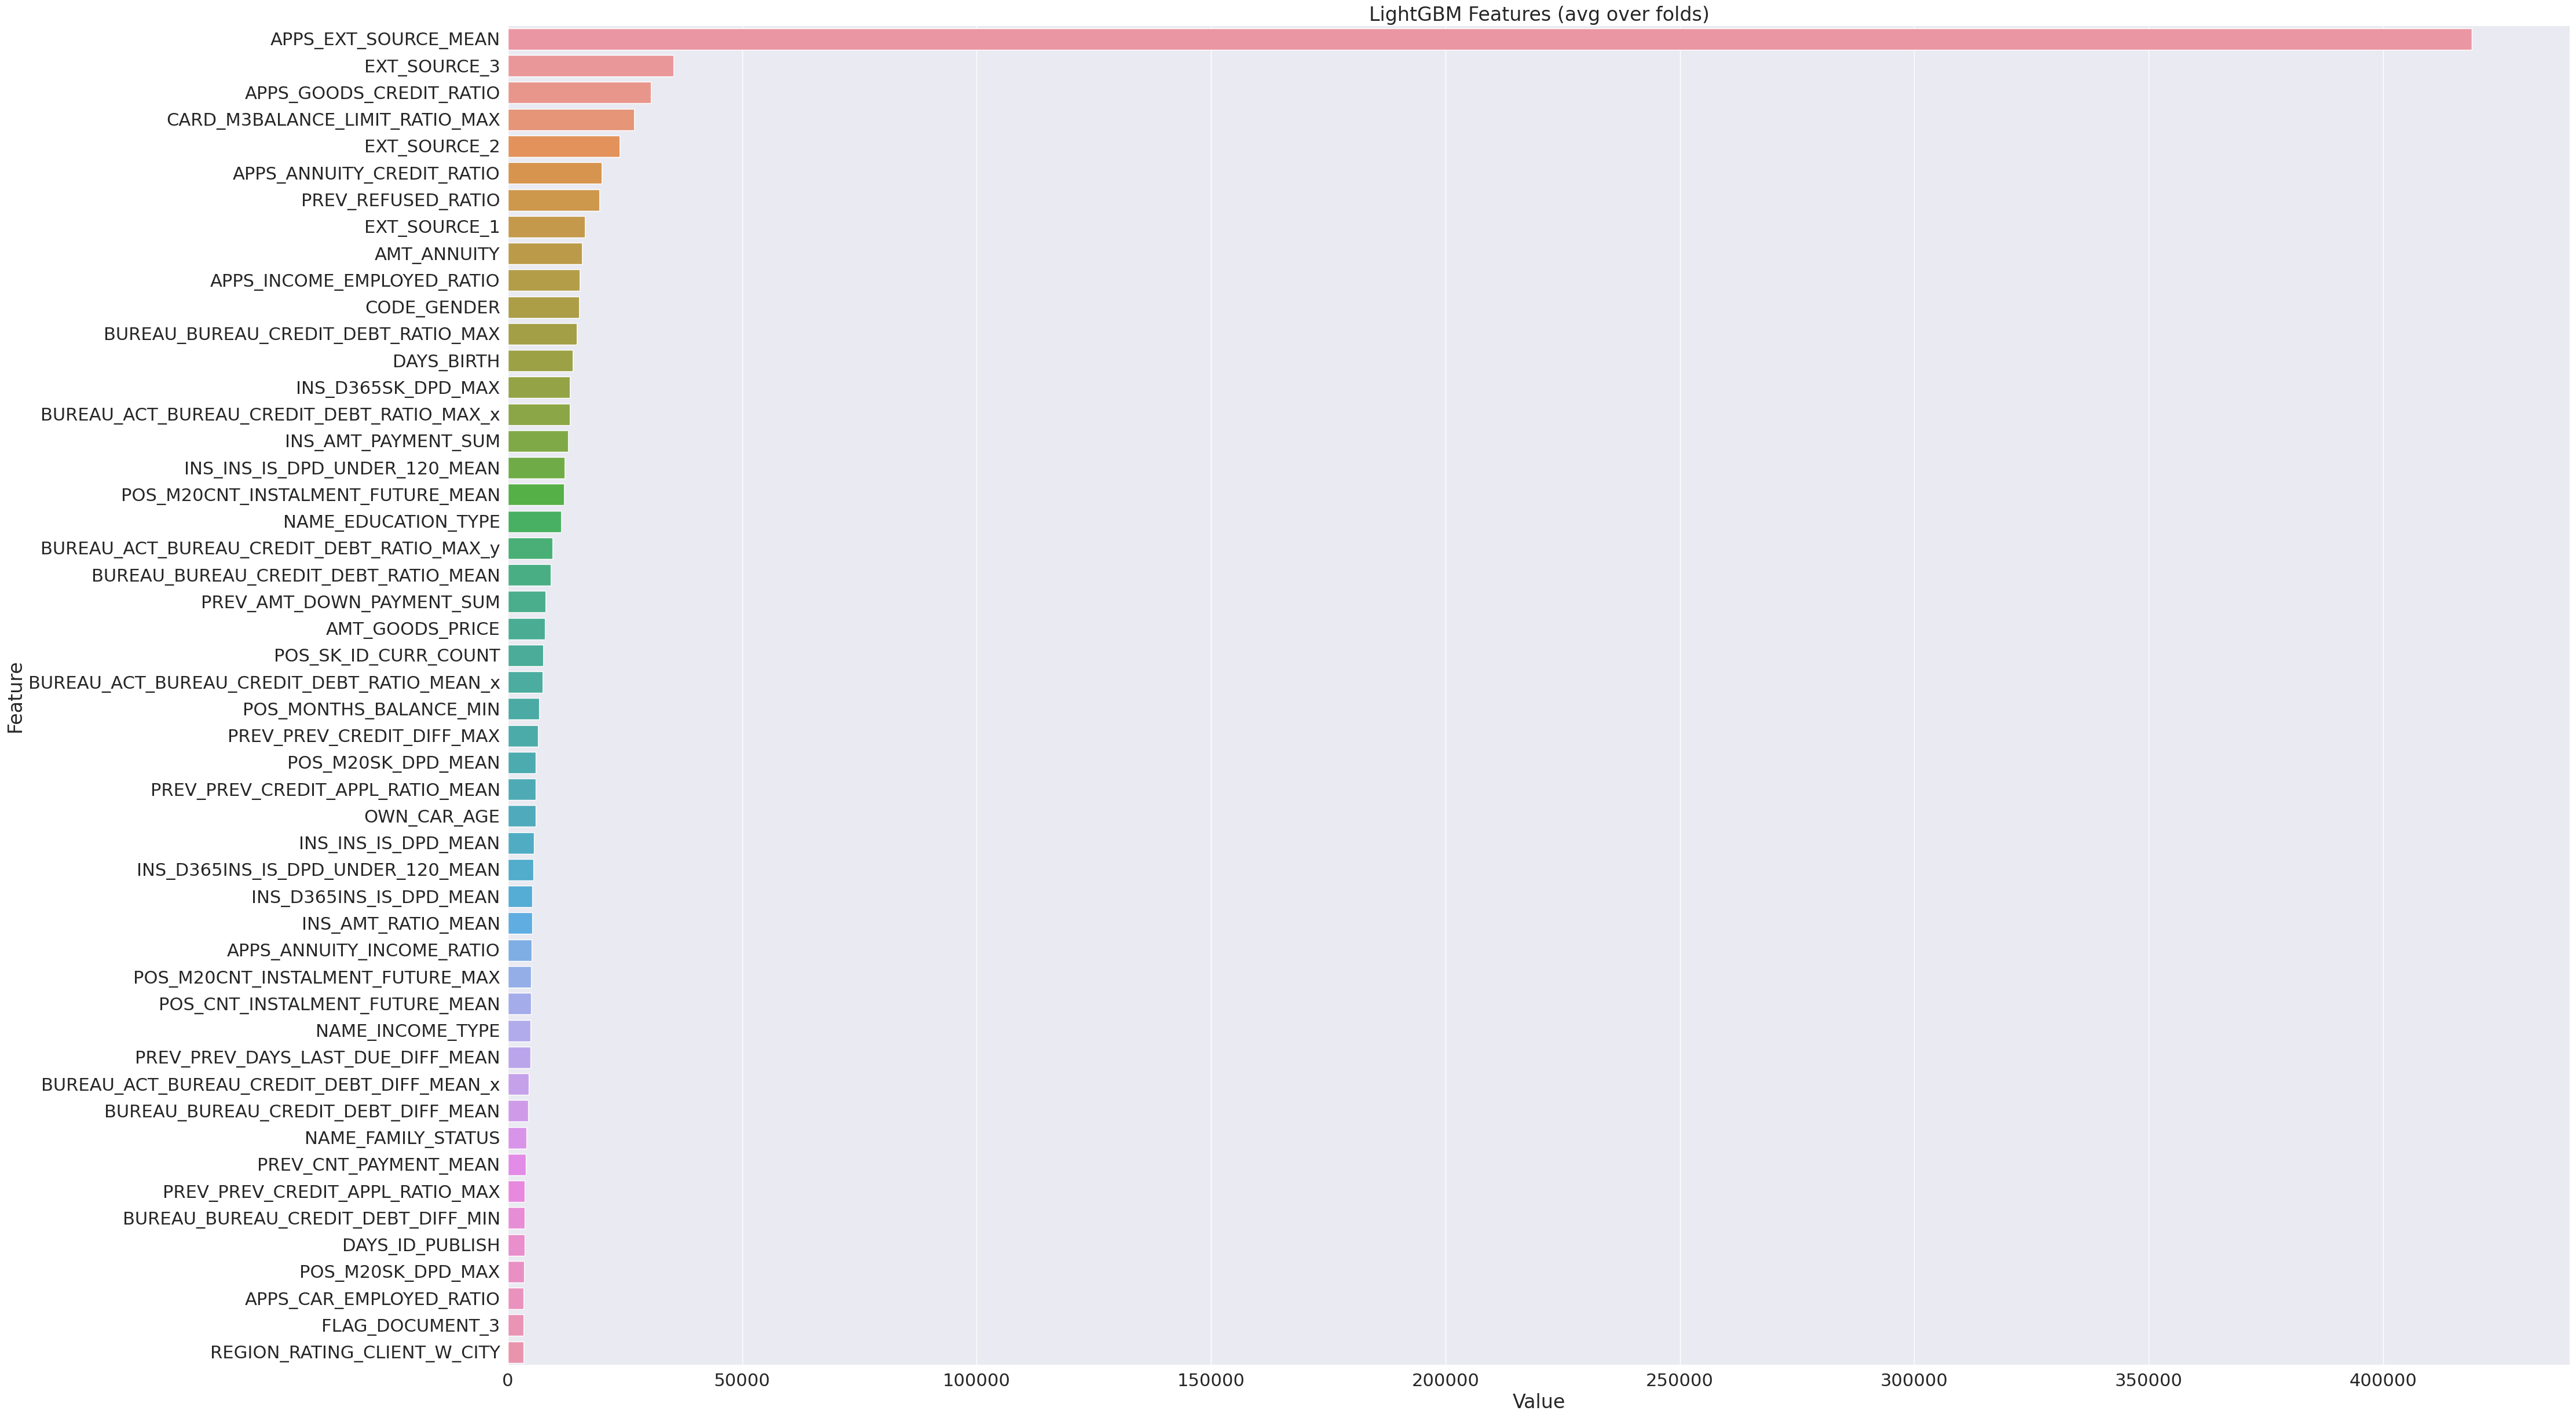

In [ ]:
plotImp(model = model_lgb_base, num = 50, font_scale = 2)

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model_lgb_base.feature_name(),
        'importance': model_lgb_base.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.to_csv('feature_importance_LGBM_ver1.csv', index = False)
df_feature_importance.sort_values(by = 'importance', ascending=False)

feature     importance
120             APPS_EXT_SOURCE_MEAN  418954.446362
41                      EXT_SOURCE_3   35295.726082
123          APPS_GOODS_CREDIT_RATIO   30565.298648
523   CARD_M3BALANCE_LIMIT_RATIO_MAX   26965.260032
40                      EXT_SOURCE_2   23902.861182
..                               ...            ...
164         PREV_PREV_GOODS_DIFF_SUM       0.000000
4                       CNT_CHILDREN       0.000000
162        PREV_PREV_GOODS_DIFF_MEAN       0.000000
163         PREV_PREV_GOODS_DIFF_MAX       0.000000
531  CARD_M3CARD_IS_DPD_OVER_120_SUM       0.000000

[532 rows x 2 columns]

In [ ]:
test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
pred = model_lgb_tune_ver0.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1))

test_kaggle['TARGET'] = pred
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index = False)

# Optuna 

In [ ]:
lgb_train = lgb.Dataset(data=train.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test.TARGET)

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
X_sub, _, Y_sub, _ = train_test_split(train[final_feature],train['TARGET'], 
                                      random_state=280, stratify=train['TARGET'])


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boost_from_average": True,
        "verbose": -1,
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int("max_bin", 20, 50),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 5, 30),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 3.0),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 3.0),
        "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 3.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1000, 3000),
        'feature_fraction' : trial.suggest_loguniform('feature_fraction', 1e-8, 1),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-8, 5)
    }
    hist_eval=dict()
    d_train = lgb.Dataset(X_sub, Y_sub)
    d_valid = lgb.Dataset(valid[final_feature], valid['TARGET'])
    model = lgb.train(params, d_train, num_boost_round=1000, valid_sets=[d_train, d_valid], 
              early_stopping_rounds=50, evals_result=hist_eval, verbose_eval = None)
    return 2*hist_eval['valid_1']['auc'][-1]-1

In [ ]:
# study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
#                             direction="maximize", sampler = TPESampler())
# study.optimize(objective, n_trials=100)
# print(study.best_trial)

In [ ]:
# study.best_params

# Model - optuna

In [ ]:
lgb_train = lgb.Dataset(data=train[final_feature],
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid[final_feature],
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test[final_feature],
                      label= test.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.18470411775002016, 
          'num_leaves': 58,
          'max_bin': 300,
          'num_iteration': 1000,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':11,
          'reg_alpha':3.564,
          'reg_lambda':4.930,
          'min_gain_to_split': 0.0010326682252577097}

model_lgb_tune_ver1 = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 16882, number of negative: 192225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.598255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108832
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 471
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080734 -> initscore=-2.432419
[LightGBM] [Info] Start training from score -2.432419
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.856315	valid_1's auc: 0.785514
[100]	training's auc: 0.898282	valid_1's auc: 0.78437
Early stopping, best iteration is:
[52]	training's auc: 0.858443	valid_1's auc: 0.785514


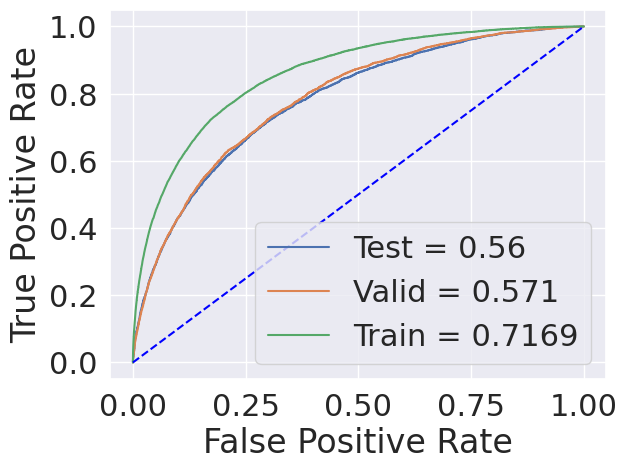

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_tune_ver1.predict(test[final_feature])
pred_valid = model_lgb_tune_ver1.predict(valid[final_feature])
pred_train = model_lgb_tune_ver1.predict(train[final_feature])

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

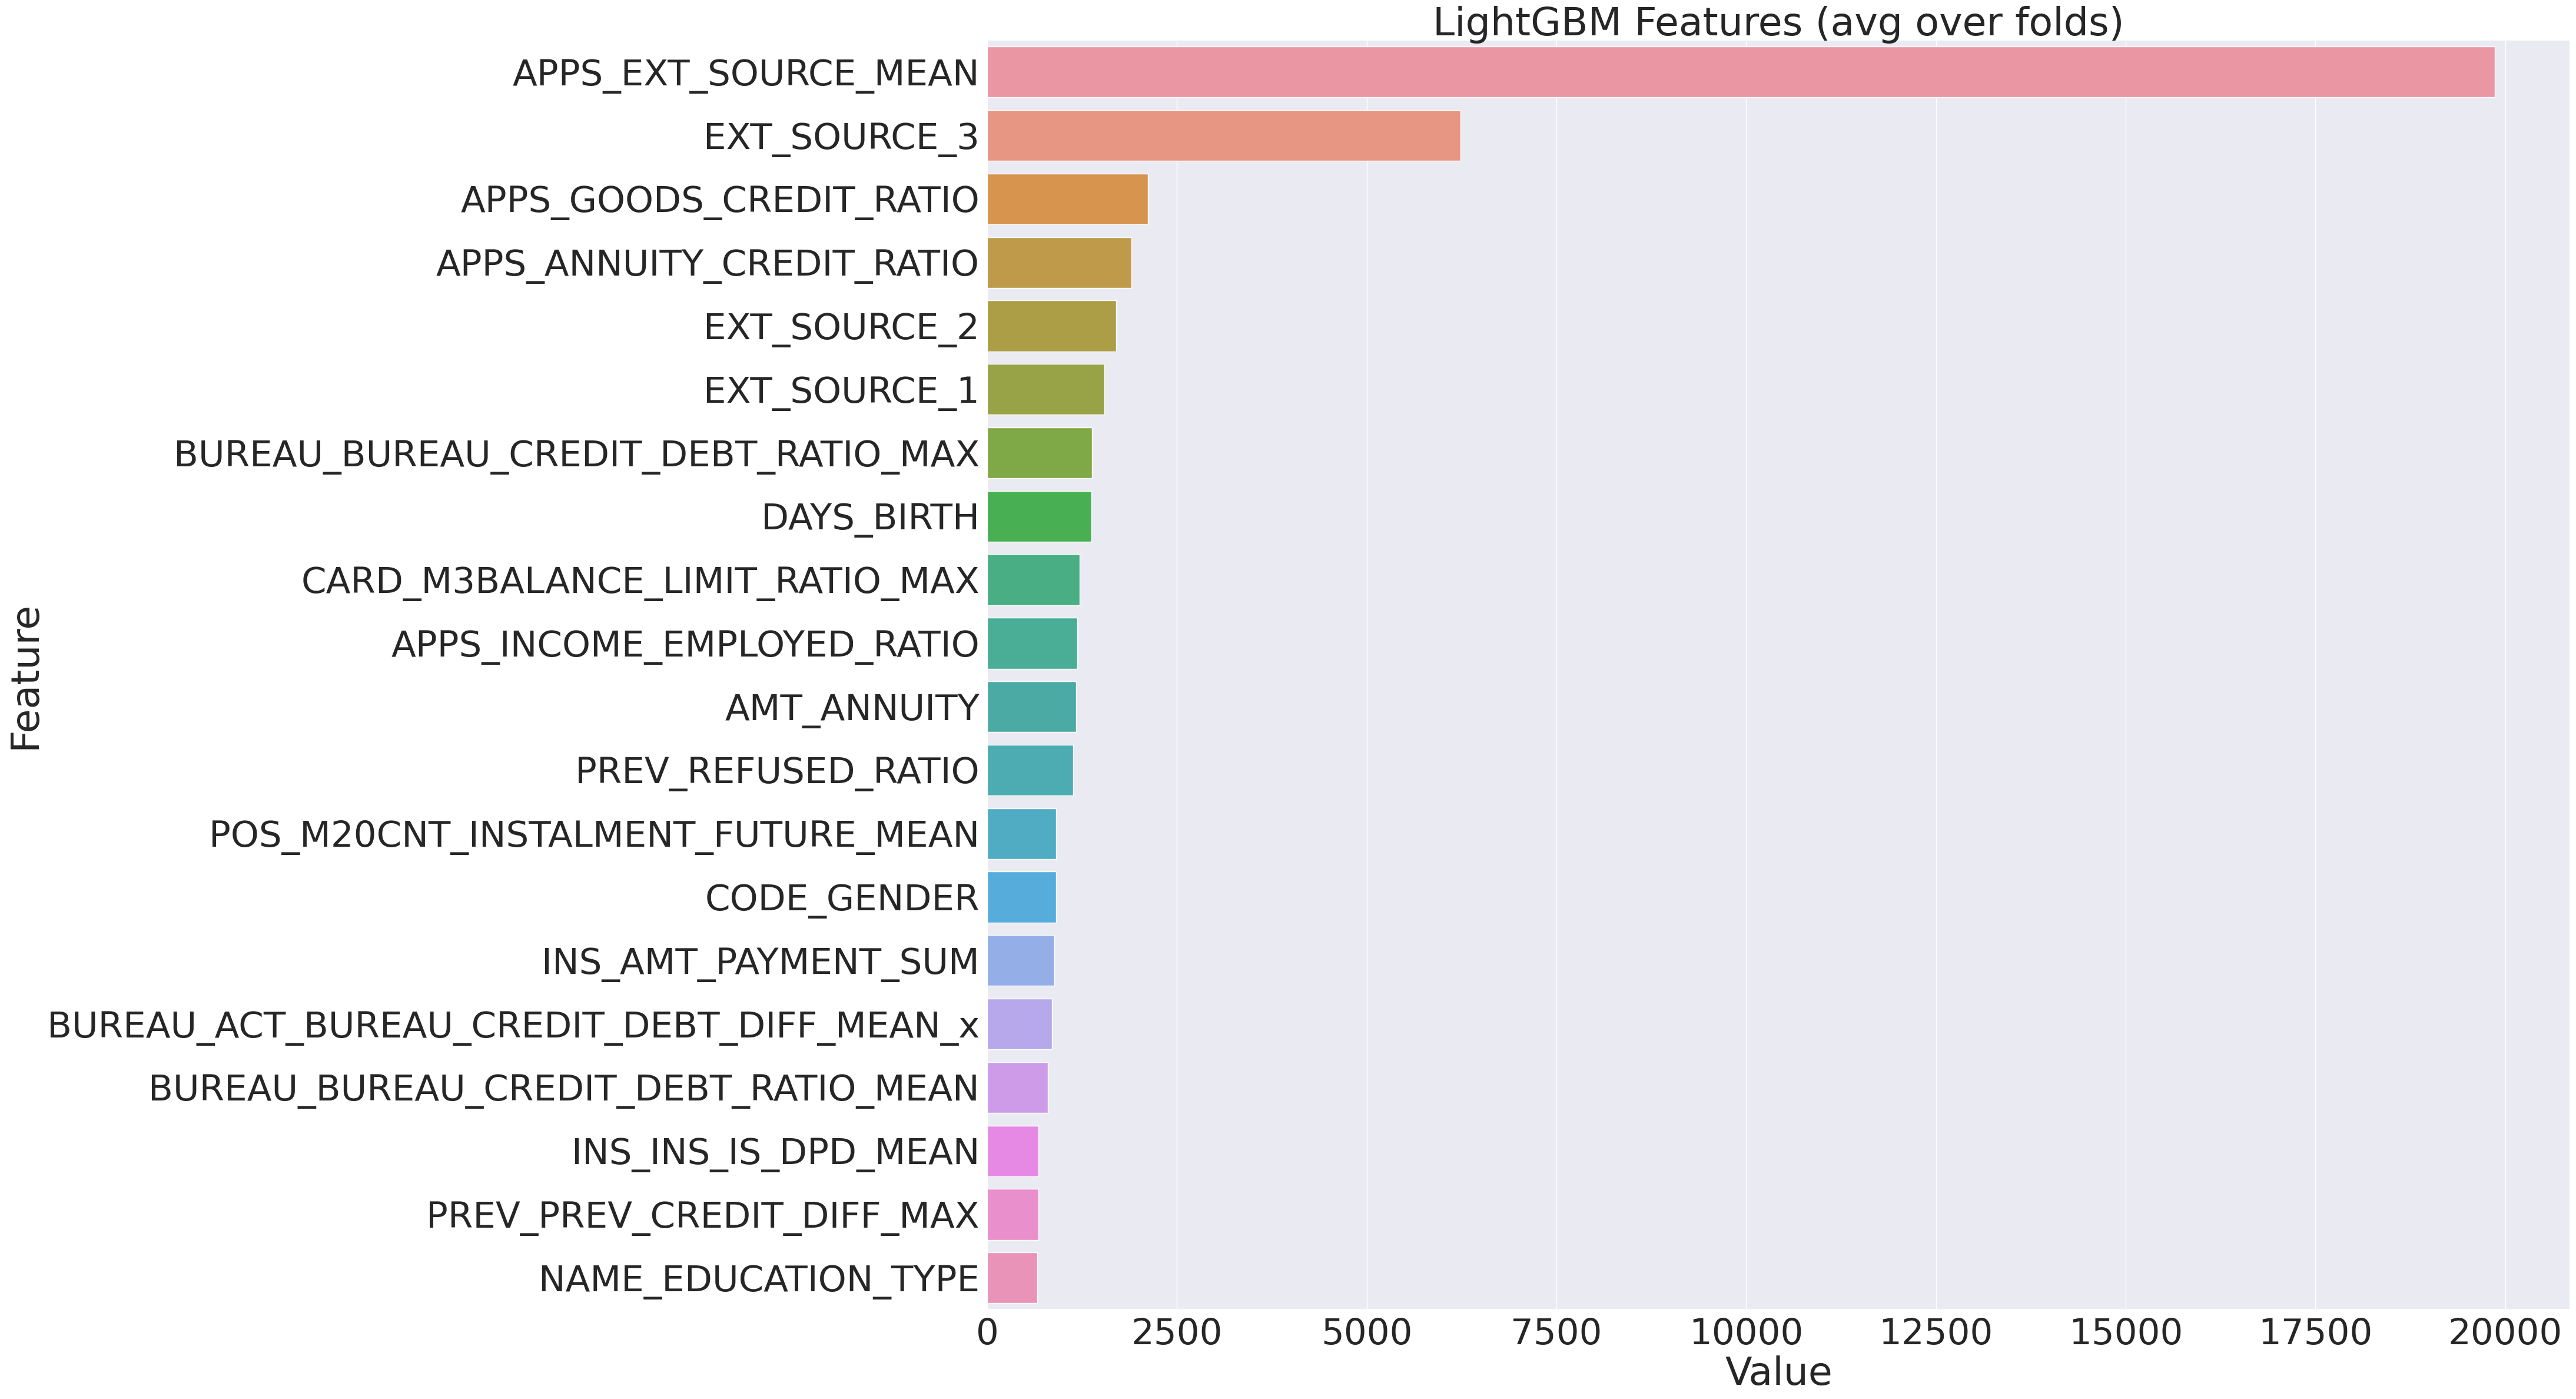

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_tune_ver1)

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model_lgb_tune_ver1.feature_name(),
        'importance': model_lgb_tune_ver1.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)


feature    importance
0                 APPS_EXT_SOURCE_MEAN  19862.776961
1                         EXT_SOURCE_3   6236.420971
2              APPS_GOODS_CREDIT_RATIO   2119.253167
5            APPS_ANNUITY_CREDIT_RATIO   1897.181522
4                         EXT_SOURCE_2   1698.806467
..                                 ...           ...
435              CARD_CARD_IS_DPD_MEAN      0.000000
436  CARD_AMT_INST_MIN_REGULARITY_MEAN      0.000000
437              INS_D365AMT_RATIO_MAX      0.000000
463            LIVE_CITY_NOT_WORK_CITY      0.000000
470       POS_POS_IS_DPD_UNDER_120_SUM      0.000000

[471 rows x 2 columns]

In [ ]:
df_feature_importance[df_feature_importance['importance']>0].shape

(377, 2)

In [ ]:
df_feature_importance.to_csv('feature_importance_LGBM_ver2.csv', index = False)

# Model_ver2

In [ ]:
feature_ver2 = df_feature_importance[df_feature_importance['importance']>0]['feature']
print(len(feature_ver2))

377


In [ ]:
lgb_train = lgb.Dataset(data=train[feature_ver2],
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid[feature_ver2],
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test[feature_ver2],
                      label= test.TARGET)

params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.18470411775002016, 
          'num_leaves': 58,
          'max_bin': 300,
          'num_iteration': 1000,
          'colsample_bytree':0.613, 
          'subsample':0.708, 
          'max_depth':11,
          'reg_alpha':3.564,
          'reg_lambda':4.930,
          'min_gain_to_split': 0.0010326682252577097}


model_lgb_tune_ver2 = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 16882, number of negative: 192225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.598686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93668
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080734 -> initscore=-2.432419
[LightGBM] [Info] Start training from score -2.432419
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.854852	valid_1's auc: 0.785893
[100]	training's auc: 0.898041	valid_1's auc: 0.78575
Early stopping, best iteration is:
[72]	training's auc: 0.876523	valid_1's auc: 0.786747


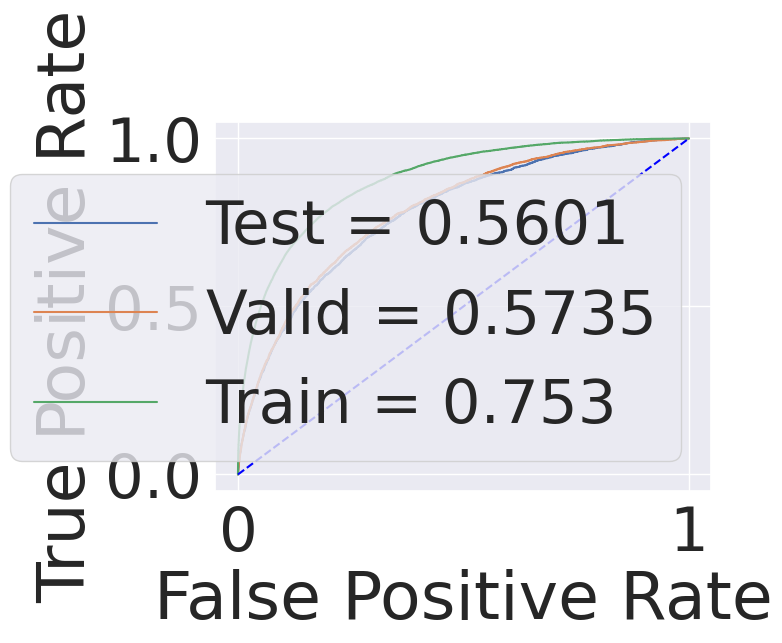

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_tune_ver2.predict(test[feature_ver2])
pred_valid = model_lgb_tune_ver2.predict(valid[feature_ver2])
pred_train = model_lgb_tune_ver2.predict(train[feature_ver2])

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model_lgb_tune_ver2.feature_name(),
        'importance': model_lgb_tune_ver2.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)


feature    importance
0               APPS_EXT_SOURCE_MEAN  21014.269450
4                       EXT_SOURCE_2   4745.759586
1                       EXT_SOURCE_3   2953.244703
3          APPS_ANNUITY_CREDIT_RATIO   2070.327716
2            APPS_GOODS_CREDIT_RATIO   1982.635716
..                               ...           ...
370         PREV_AMT_APPLICATION_MAX      0.000000
362   CARD_M3DRAWING_LIMIT_RATIO_MIN      0.000000
351             INS_D365AMT_DIFF_MIN      0.000000
323  CARD_M3AMT_DRAWINGS_CURRENT_MAX      0.000000
331            POS_M20POS_IS_DPD_SUM      0.000000

[377 rows x 2 columns]

In [ ]:
feature_ver3 = df_feature_importance[df_feature_importance['importance']>0]['feature']
print(len(feature_ver3), len(feature_ver2))

370 377


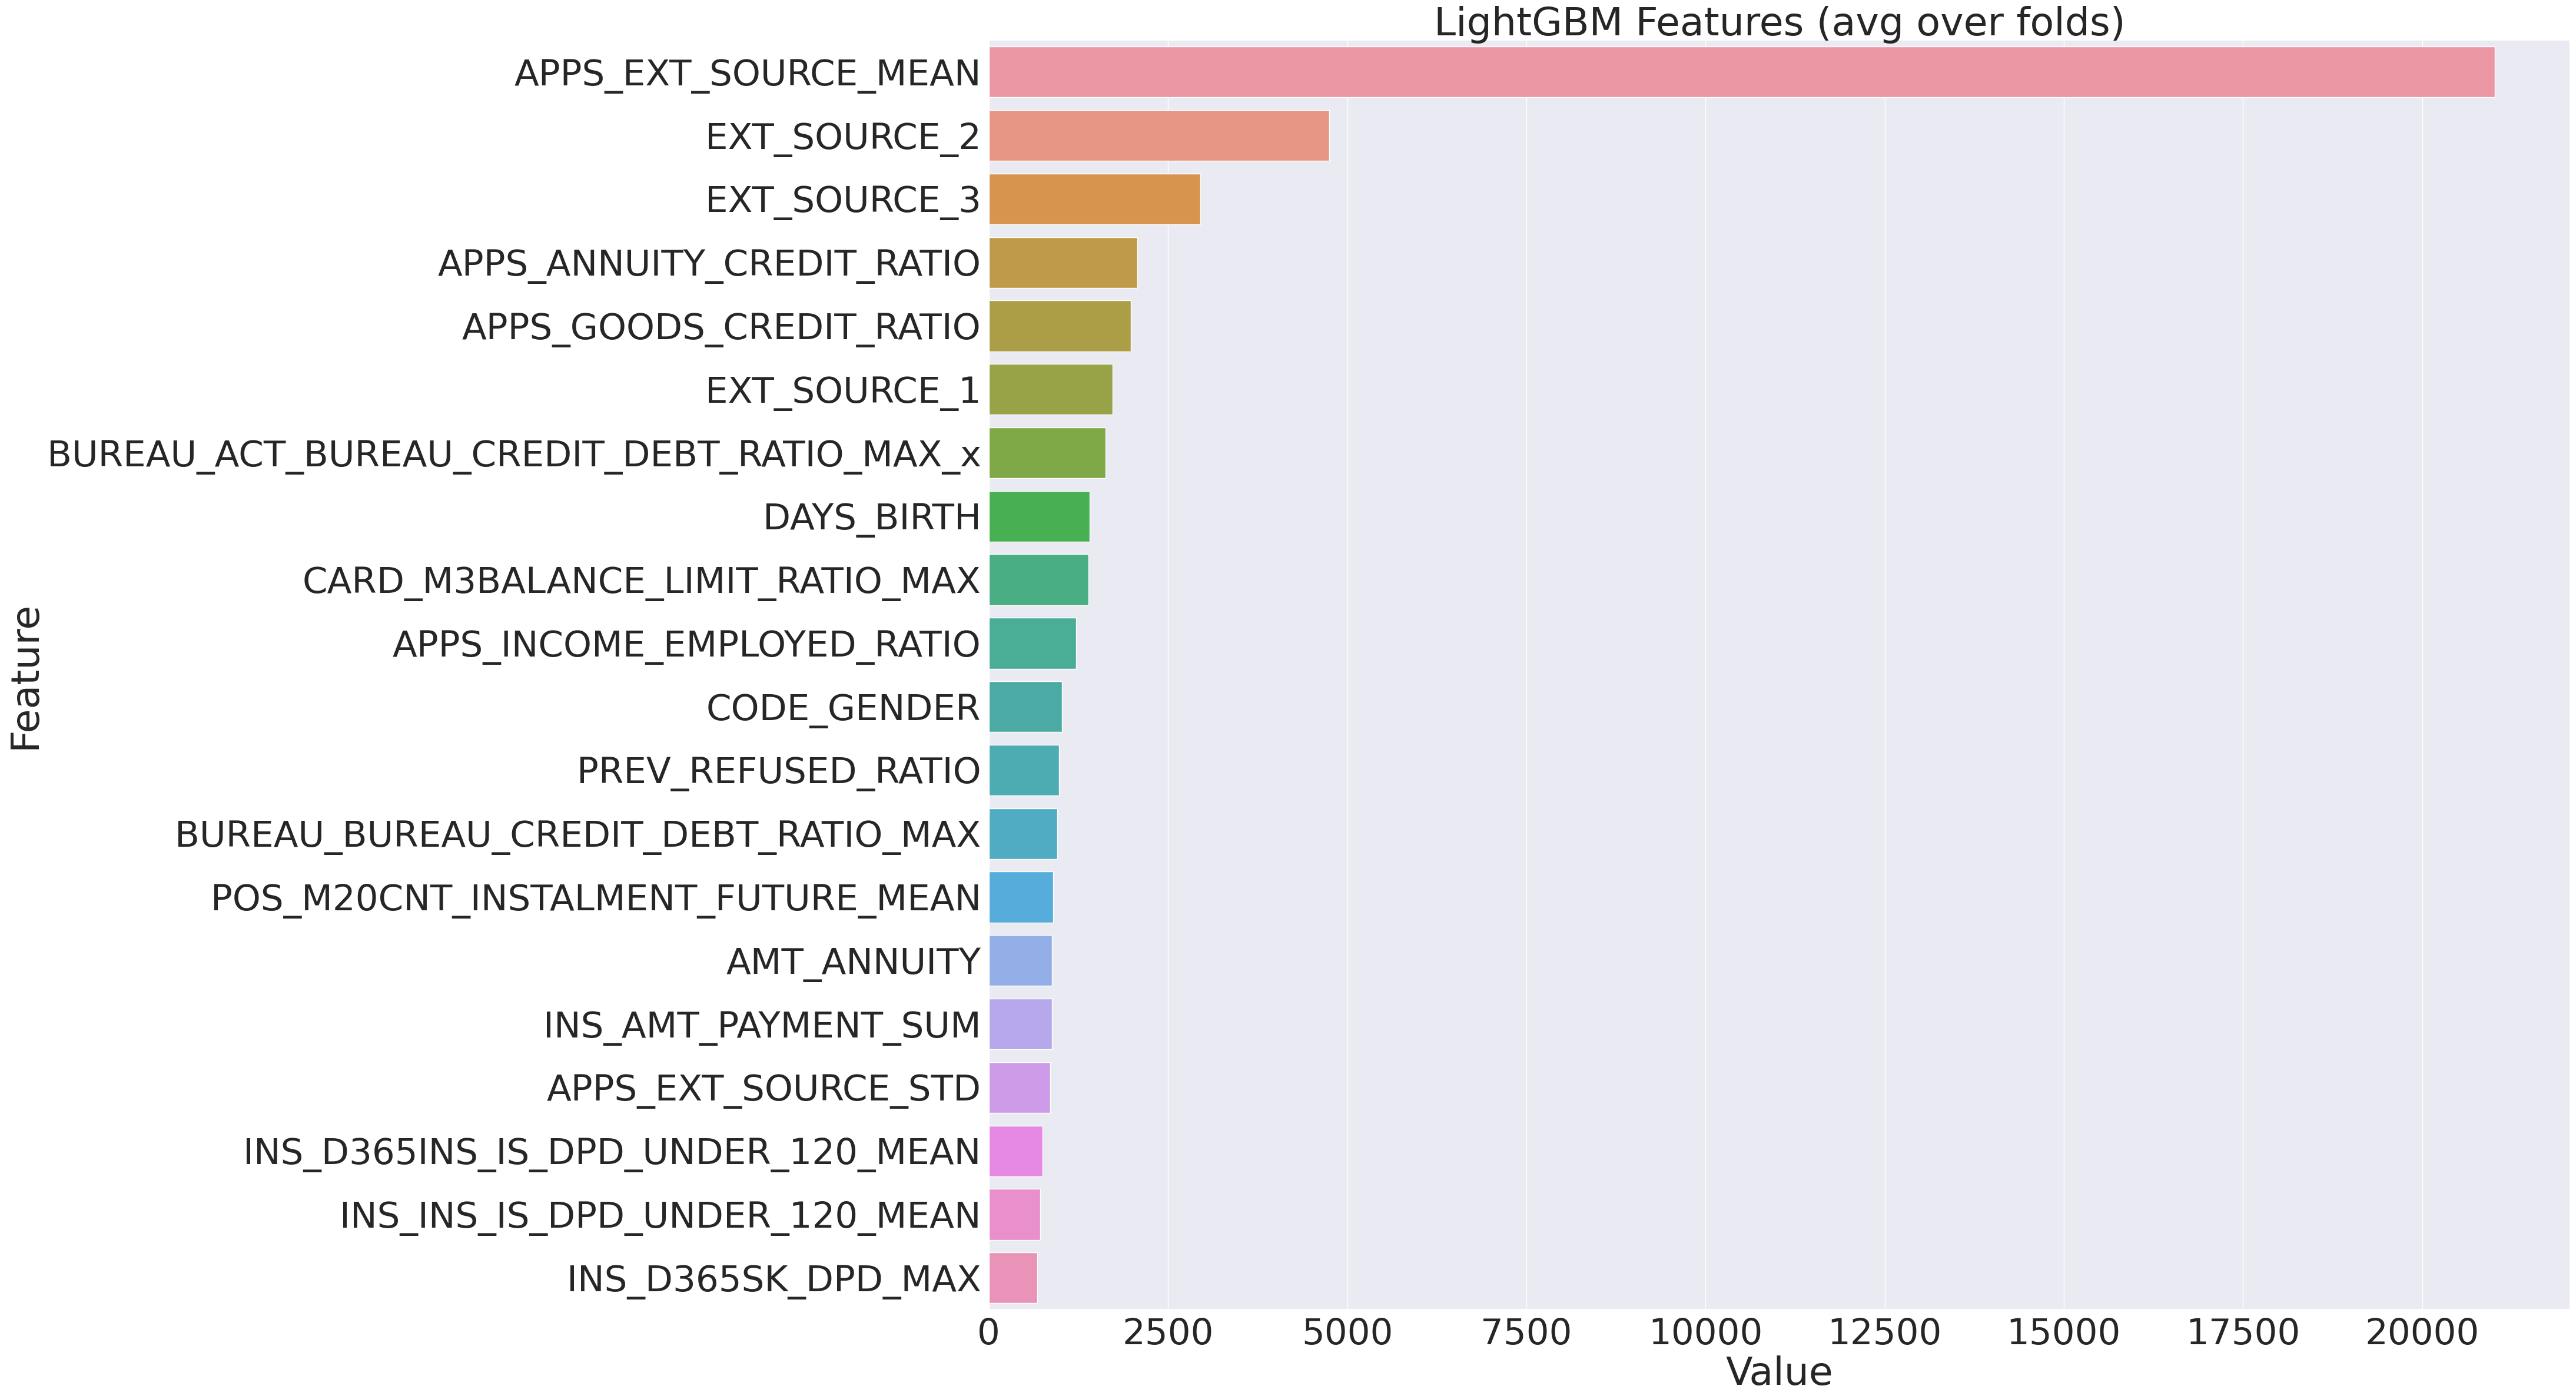

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

plotImp(model = model_lgb_tune_ver2)

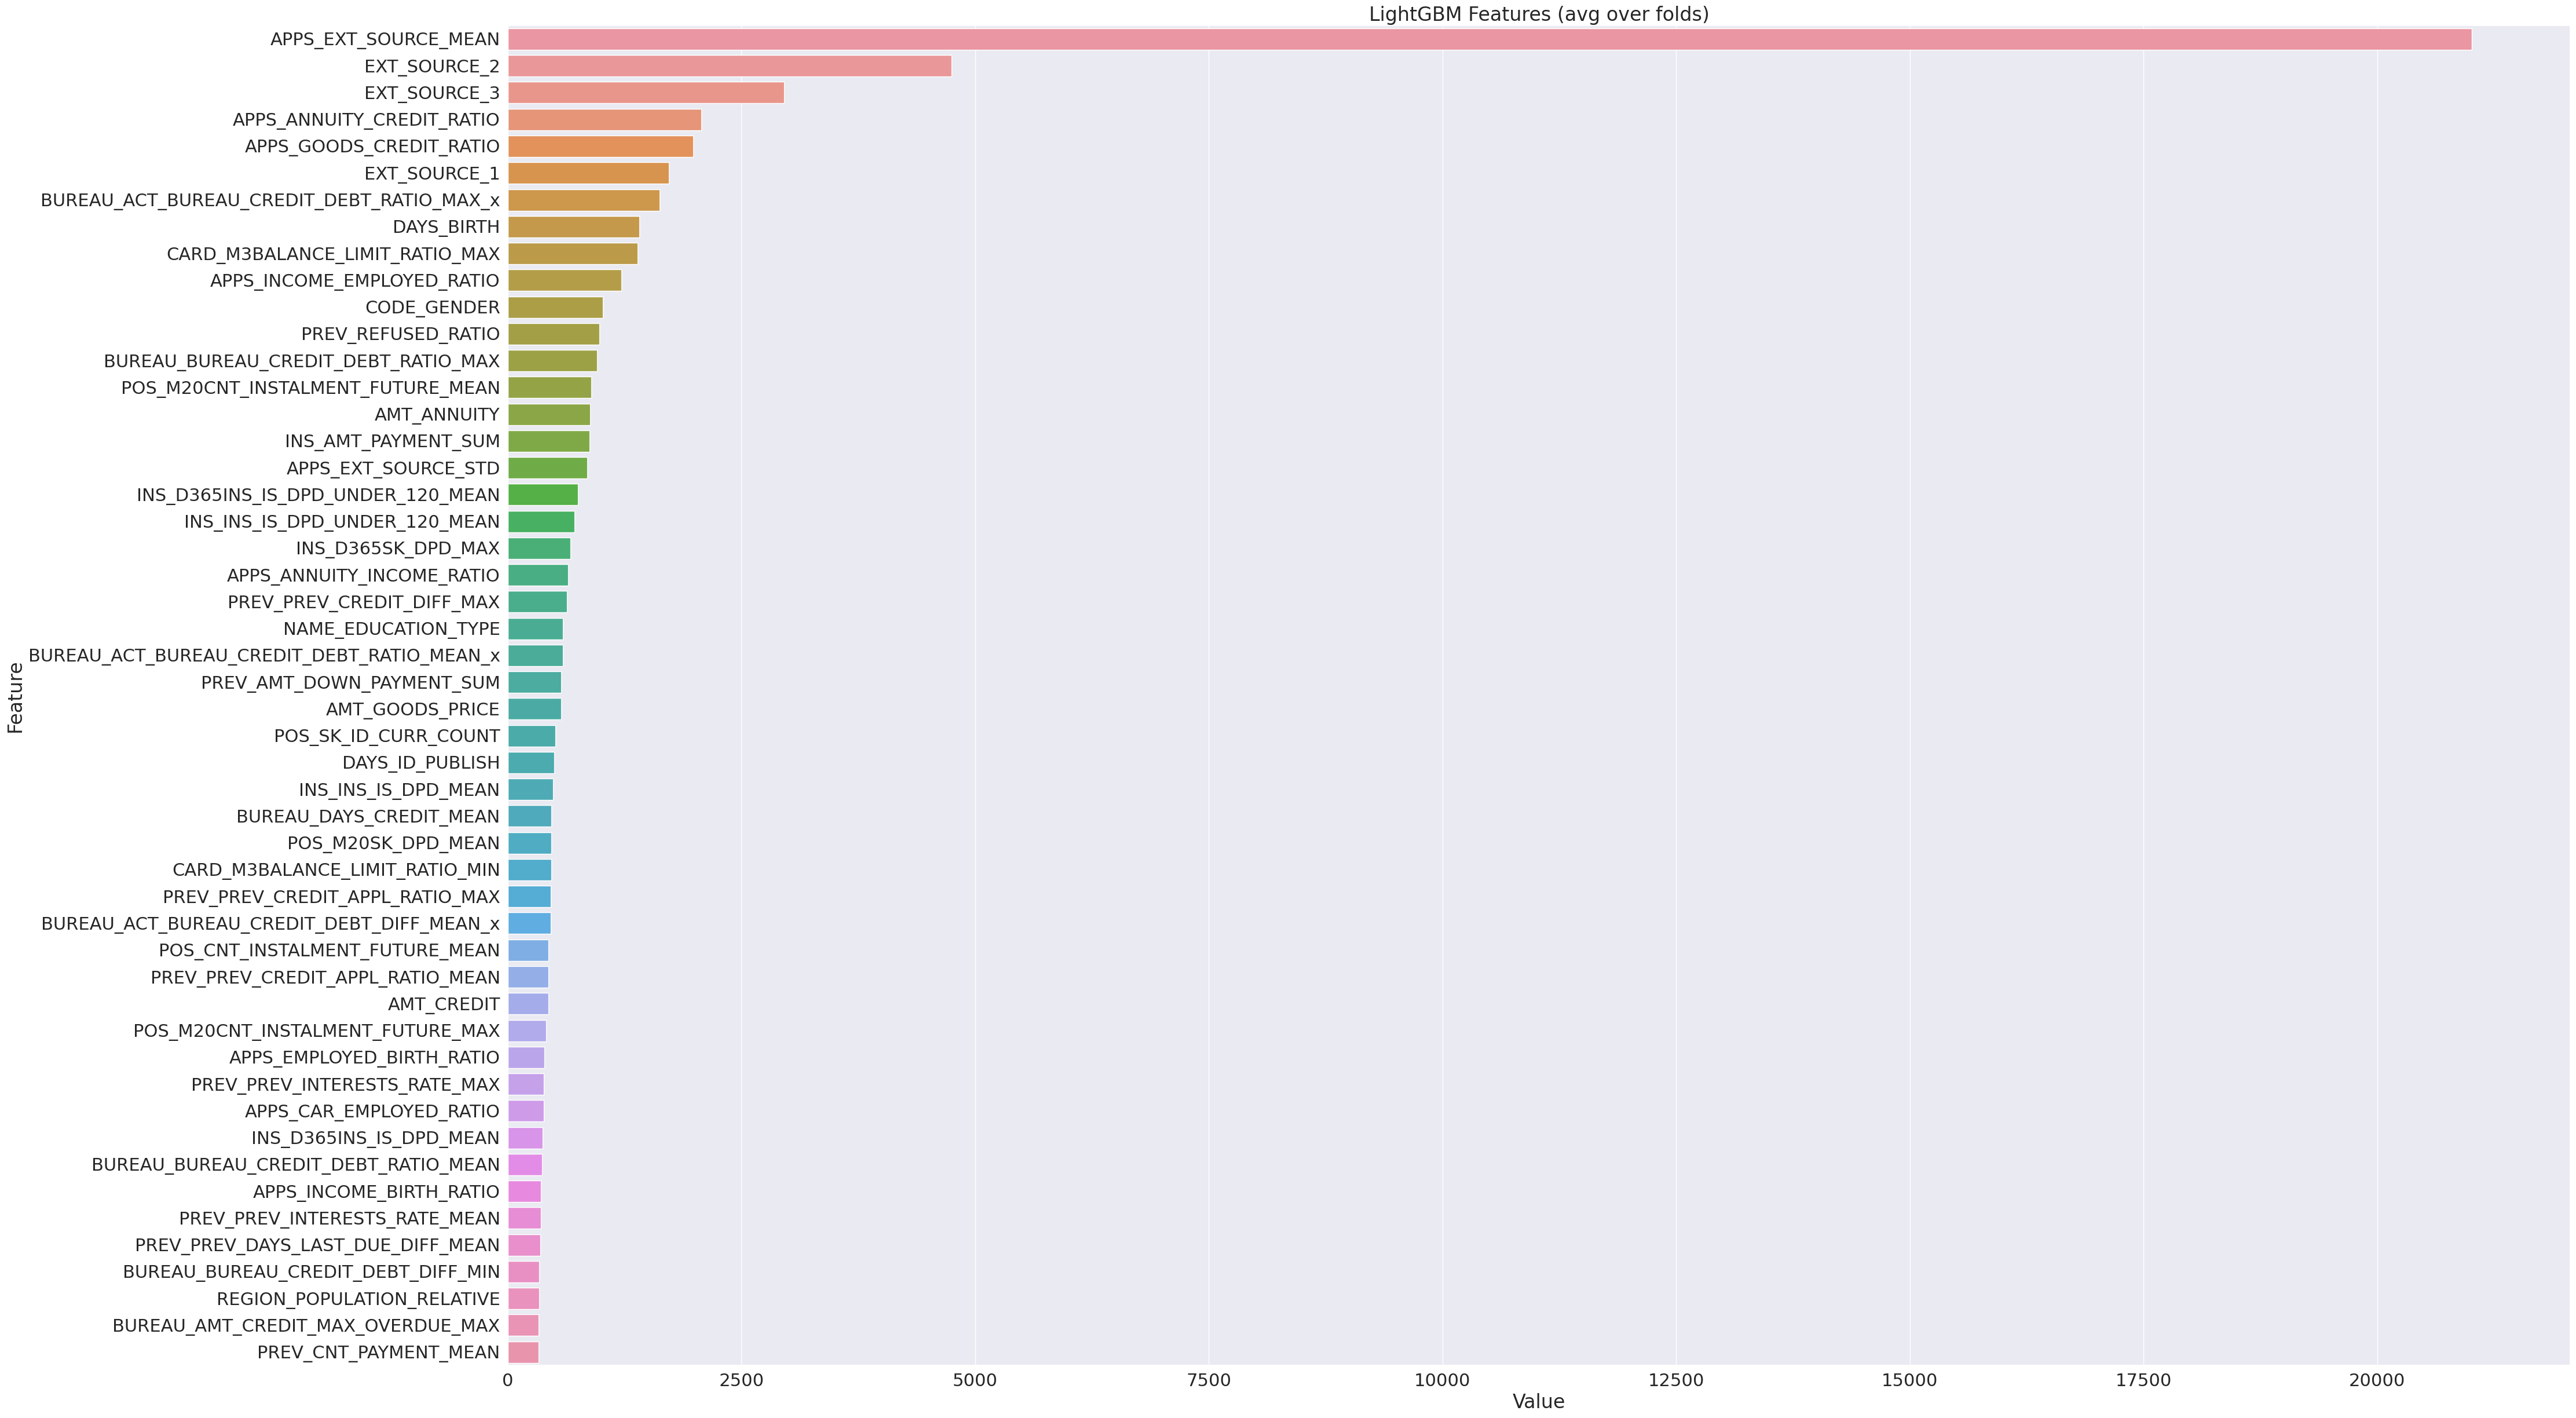

In [ ]:
plotImp(model = model_lgb_tune_ver2, num = 50, font_scale= 2)

In [ ]:
# df_feature_importance.to_csv('')

# Prediction

In [ ]:
# test_kaggle = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/create_feature_test_kaggle_ver2.pkl')
# pred = model_lgb_tune_ver1.predict(test_kaggle[final_feature])
# test_kaggle['TARGET'] = pred
# test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)